<a href="https://colab.research.google.com/github/anandchauhan21/pomegranate_disease_prediction/blob/main/pomodetectPredict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Load libraries
import numpy as np
import cv2
from skimage import data
from skimage.color import rgb2hsv
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPool2D, Dropout
#from tensorflow.keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import MaxPooling2D
from google.colab.patches import cv2_imshow
print('Libraries imported...')

Libraries imported...


In [ ]:
# function to detect pomo
def PomoDetect(curImgt):
    # image pre processing
    #cv2.imshow('RGB image', curImgt)
    I = cv2.cvtColor(curImgt, cv2.COLOR_BGR2RGB)  # convert BGR to RGB image
    Igray = cv2.cvtColor(curImgt, cv2.COLOR_BGR2GRAY)  # covert image to grayscale
    Ig = cv2.GaussianBlur(I, (19, 19), 0)  # apply gaussian blur
    # print('Gaussian blurred')
    # Ig = cv2.medianBlur(I, 5)# change this for changing blurring method

    # HSV Conversions
    Ihsv = rgb2hsv(Ig)  # convert gaussian blurred image to HSV
    Ih = np.uint8(255 * Ihsv[:, :, 0])  # hue plane is in range 0-1, change to 0-255 range

    # HSV Filtering for upper hue band
    Hmin = 230
    Hmax = 255
    Ib1 = ((Ih <= Hmax) & (Ih >= Hmin))  # create BW mask within hue range
    # plt.imshow(Ib1, cmap='gray')
    # plt.title('hue mask1')
    # plt.show()

    # HSV Filtering for lower hue band
    Hmin = 0
    Hmax = 30
    Ib2 = ((Ih <= Hmax) & (Ih >= Hmin))  # create BW mask within hue range
    # plt.imshow(Ib2, cmap='gray')
    # plt.title('hue mask2')
    # plt.show()

    # Combining both HSV Filtered mask
    Ib = np.uint8(255 * (Ib1 | Ib2))
    # plt.imshow(Ib, cmap='gray')
    # plt.title('combine hue mask')
    # plt.show()
    # print('HSV Filtering')

    # Filter using contour area and remove small white regions
    cnts = cv2.findContours(Ib, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        area = cv2.contourArea(c)
        if area < 10000:  # blank all regions less than this pixel area
            cv2.drawContours(Ib, [c], -1, (0, 0, 0), -1)

    # Morph close the inner black regions
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (20, 20))  # create structure element for closing operation
    Iclose = np.uint8(cv2.morphologyEx(Ib, cv2.MORPH_CLOSE, kernel, iterations=2))  # apply morphology closing operation
    # print('Applying contour filtering')
    # print(Iclose[50,:])
    # plt.imshow(Iclose, cmap='gray')
    # plt.title('countour')
    # plt.show()

    # find circles in the BW mask image
    Cmax = 70  # maximum cutt off threshold for circle detection
    NCir = 0  # no of circles assumed 0
    RadMin = 150
    RadMax = 300
    H, W = Iclose.shape
    # print (H,'x', W)
    while NCir == 0 and Cmax > 0:  # run loop till circle detected or Circle Threshold >0
        circles = cv2.HoughCircles(np.uint8(Iclose), cv2.HOUGH_GRADIENT, 2, minDist=100, param1=100,
                                   param2=Cmax, minRadius=RadMin, maxRadius=RadMax)
        # ax = plt.gca()
        if circles is None:  # if no circles detected
            # print('No circles, Cmax=', Cmax)
            NCir = 0
            Cmax = Cmax - 2,  # reduce the Circle Threshold value and repeat the circle detection
            Cmax = Cmax[0]
        else:
            circles2 = np.int16(circles)  # get circles into integer
            NCir = len(circles2[0])  # total circles
            # print('total circles=', NCir)
            # print(circles)
            # for circle in circles2[0, 0]:

            i = circles2[0][0]  # first circle location
            i = np.array(i)
            # tc=circles2[0,:]
            # i=tc[5]
            # print(i)
            # draw the main circle of pomo detected area
            # c1 = plt.Circle((i[0], i[1]), i[2], facecolor='none', edgecolor='b')# draw circle
            # draw the center of the circle
            # c2 = plt.Circle((i[0], i[1]), 2, facecolor='none', edgecolor='b')# draw centre of circle
            Ymin = i[0] - i[2]  # Xmin of circle
            Ymax = i[0] + i[2]  # xmax of circle
            Xmin = i[1] - i[2]  # ymiin of circle
            Xmax = i[1] + i[2]  # ymax of circle
            if Xmin < 0:  # if xmin is less than 0, limit to 0
                Xmin = 0
            if Ymin < 0:
                Ymin = 0
            if Xmax > H:  # if max is > image size limit to H,W
                Xmax = H
            if Ymax > W:
                Ymax = W
            # img = cv2.rectangle(Iclose, (Xmin, Ymin), (Xmax, Ymax), (255, 0, 0))
            # cv2.imshow('Cropped', img)

            # print(Xmin, ':', Xmax, ',', Ymin, ':', Ymax)
            Icut = Igray[Ymin:Ymax, Xmin:Xmax]  # crop the circle image area and return it
            # plt.imshow(Icut, cmap='gray')
            # plt.title('Crop image')
            # plt.show()
            # cv2.imshow('cropped', Icut)
            #        ax.add_artist(c1)
            #        ax.add_artist(c2)

            #      plt.imshow(I, cmap='gray')
            #      plt.title('detected')
            #      plt.show()
    return Icut

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# resize immage height and width
RH = 250
RW = 250

In [ ]:
## Load model from disk
current_path = os.getcwd()
Model_Path = os.path.join(current_path,'drive','MyDrive','Colab Notebooks','model.h5')
print('Current Path = ',Model_Path)
model = tf.keras.models.load_model(Model_Path)
print('Model loaded')
Colab_Path = os.path.join(current_path,'drive','MyDrive','Colab Notebooks')

Current Path =  /content/drive/MyDrive/Colab Notebooks/model.h5
Model loaded


In [ ]:
####### Enter your test image in path ########
crnt_path ='/content/drive/'
FilePath = os.path.join(crnt_path,'MyDrive','Colab Notebooks', 'mypomData','0','img001-00001.jpg')
print('File path=',FilePath)

File path= /content/drive/MyDrive/Colab Notebooks/mypomData/0/img001-00001.jpg


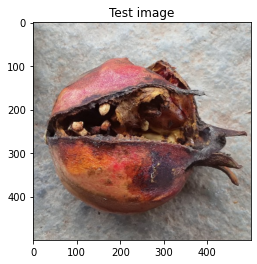

In [ ]:
test_image=cv2.imread(FilePath)#read image in grayscale
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB), cmap='gray')
plt.title('Test image')
plt.show()

#print('Test image size=', str(test_image_array.size))
test_pomo = PomoDetect(test_image)


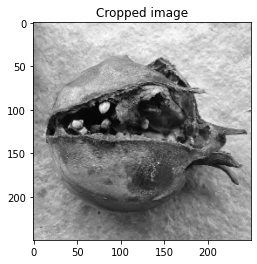

In [ ]:
# resizing image
test_image_resize=cv2.resize(test_pomo, (RH, RW))# resizei mage to 125x125
plt.imshow(test_image_resize, cmap='gray')
plt.title('Cropped image')
plt.show()
test_image_resize = test_image_resize/255.0 # change 0,255 to 0,1 range


In [ ]:
#predict the disease
test_image_reshape = np.array(test_image_resize).reshape(-1, RH, RW, 1) # reshape for neural network prediction
pred = np.array(model.predict(test_image_reshape))[0]# prect the image

prediction = np.ceil(pred*100)/100 # convert figures to nearest round figures
print('prediction = '+str(prediction))

MaxPredict = np.amax(prediction)
print('Prediction Val = '+str(MaxPredict))

prediction = [1.   0.01 0.01 0.01]
Prediction Val = 1.0


In [ ]:
result = np.array(np.where(prediction == MaxPredict))[0][0]
print('Prediction ID = '+str(result))
dis = ['Bacterial Blight', 'Alternaria', 'Cercospora', 'Anthracnose']
print('disease type = '+dis[np.int(result)])

Prediction ID = 0
disease type = Bacterial Blight


---Desease cure---------
Reference: https://www.krishisewa.com/articles/disease-management/398-pomegranate-diseases.html


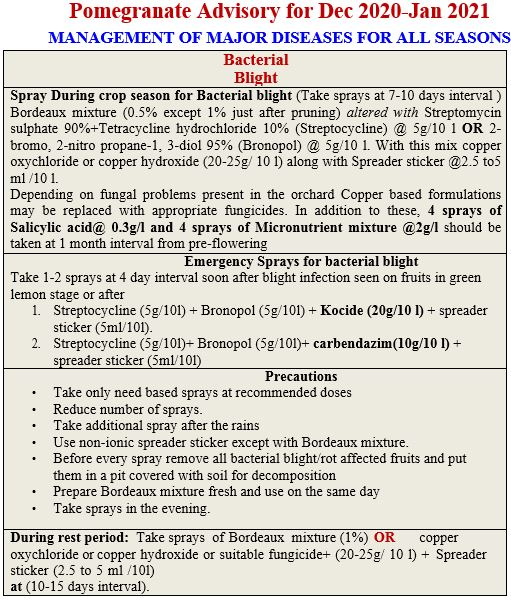

In [ ]:
# Disease cure
print('---Desease cure---------')
print('Reference: https://www.krishisewa.com/articles/disease-management/398-pomegranate-diseases.html')
if result == 0:
    Ibb = cv2.imread(os.path.join(Colab_Path,'solution','bacterial blight1.JPG'))
    cv2_imshow(Ibb)
elif result == 1 or result == 2:
    Ibb = cv2.imread(os.path.join(Colab_Path,'solution','Alternaria-Cercospora.jpg'))
    cv2_imshow(Ibb)
else:
    Ibb = cv2.imread(os.path.join(Colab_Path,'solution','Anthracnose.JPG'))
    cv2_imshow(Ibb)